In [37]:
import os
import itertools
import glob
import datetime
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt
import PIL.Image


sns.set(font_scale=1.0, style='ticks', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [38]:
IMAGE_DIR = "../pkg/model/images"
IMAGE_LOG = "../pkg/model/image_log_with_alt.csv"
IMAGES = {
    "ocean": "4520800",
    "land": "15916400",
    "cloud": "4427200",
    "night": "14400000",
}

In [39]:
# figure out where the images were taken
LOCATIONS = {}

i = set(IMAGES.values())
with open(IMAGE_LOG) as f:
    for line in f:
        s = line.split(",")[0]

        if s in i:
            print(s, line)
            _, lat, lon, alt, sunlit = line.strip().split(",")
            LOCATIONS[s] = {
                "lat": float(lat),
                "lon": float(lon),
                "alt": float(alt),
                "sunlit": sunlit == "True",
            }

4427200 4427200,50.535,152.457,487.243,1

4520800 4520800,44.681,150.388,485.965,1

14400000 14400000,44.655,-85.374,478.465,0

15916400 15916400,38.124,101.394,484.482,1



In [40]:
def cld_cloud_percentage(image):
    # don't ask why, but there are some images where a CLD pixel is above 100
    return np.sum(np.clip(image, 0, 100)) / 100 / (image.shape[0] * image.shape[1])

In [41]:
def read_image(image_path):
    # basically a zip file of a bunch of tiffs
    # ..._B01.tiff, ..._B02.tiff, etc.
    with zipfile.ZipFile(image_path) as zf:
        # print(f"Reading {os.path.basename(image_path)}")
        with zf.open(f"{os.path.basename(image_path)[:-4]}_CLD.tiff") as f:
            return np.array(PIL.Image.open(f))


In [42]:
CLOUD_COVERS = {}
for i in IMAGES.values():
    c = cld_cloud_percentage(read_image(os.path.join(IMAGE_DIR, f"{i}.zip"))) * 100
    print(i, c, "%")
    CLOUD_COVERS[i] = c

4520800 0.00439453125 %
15916400 0.069244384765625 %
4427200 100.0 %
14400000 100.0 %


webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped


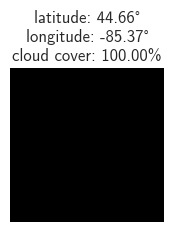

In [43]:
FACTOR = 2
for k, i in IMAGES.items():
    with zipfile.ZipFile(os.path.join(IMAGE_DIR, f"{i}.zip")) as zf:
        with zf.open(f"{i}_B04.tiff") as f:
            r_band =  np.array(PIL.Image.open(f)).astype(np.float64) / 255.0

        with zf.open(f"{i}_B03.tiff") as f:
            g_band =  np.array(PIL.Image.open(f)).astype(np.float64) / 255.0

        with zf.open(f"{i}_B02.tiff") as f:
            b_band =  np.array(PIL.Image.open(f)).astype(np.float64) / 255.0

        img = np.stack([r_band, g_band, b_band], axis=-1)

        g = plt.imshow(img * FACTOR)
        # turn off gridlines
        plt.grid(False)
        # remove axes
        plt.axis('off')

        # add title text
        plt.title(f"latitude: {LOCATIONS[i]['lat']:.2f}°\nlongitude: {LOCATIONS[i]['lon']:.2f}°\ncloud cover: {CLOUD_COVERS[i]:.2f}%")
        plt.savefig(f"example-{k}.pdf", bbox_inches='tight', pad_inches=0)